# PCA Plots

## General settings and loading files

In [1]:
%%time

% matplotlib inline
% load_ext autoreload
% autoreload 2

% run general_settings.py
# ^ Takes ~20s to run if it finds the dumpfiles
# ^ WARNING: It will hog ~2.02 Gb RAM


[20:41:56] 'panels' dict
[20:41:56] 'galanter', 'present', 'missing' dataframes
[20:41:56] 'panel_labels'
[20:41:56] 'panel_names' dict
[20:41:56] 'panel_rsIDs' dict
[20:41:56] 'genome' dataframe
[20:42:01] 'lat' dataframe
[20:42:12] 'control_genotypes' huge datagrame
[20:42:12] 'control_rsIDs' dict to filter it ^
[20:42:12] 'cp_factors' list
[20:42:12] 'control_names' dict
[20:42:12] 'df_1000G_samples'
[20:42:12] 'df_1000G_SNPs'
[20:42:12] 'df_1000G_genotypes'
[20:42:12] 'df_1000G_populations'
[20:42:13] 'df_1000G_genotypes_alleles'

/home/juan/repos/tesina/settings/genome.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  centromers["chromosome"] = [i.replace("CEN", "") for i in centromers.index]
/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1572: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())



[20:42:13] 'mafs' dataframe
CPU times: user 15.8 s, sys: 1.82 s, total: 17.6 s
Wall time: 17.4 s


/home/juan/anaconda3/lib/python3.5/site-packages/pandas/io/parsers.py:1574: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


## Create the datasets
Lists of sample IDs of chosen populations to later filter 1000 Genomes data.

In [2]:
from collections import OrderedDict
from os.path import join

DATASETS_DIR = "/home/juan/tesina/dataset_dumps/"


def sample_IDs_from_popcode(pop_dict):  
    populations = []
    for label, pop_list in pop_dict.items():
        mask = df_1000G_samples.population.isin(pop_list)
        populations.append(df_1000G_samples[mask])

    return pd.concat(populations).index

dataset_names = {
    "L": "Latinos",
    "LE": "Latinos, Europeos",
    "LEA": "Latinos, Europeos, Africanos",
    "LEAC": "Latinos, Europeos, Africanos, Chinos",
    "LEACI": "Latinos, Europeos, Africanos, Chinos, Indios",
}

# I could export some of these to .yaml ?

latinos = {'latinos': ['PEL', 'MXL', 'CLM', 'PUR']}
e = {'europeans': ['IBS', 'GBR']}
ea = {**e, **{'africans': ['YRI', 'LWK']}}
eac = {**ea, **{'east_asians': ['CHB', 'CHS']}}
eaci = {**eac, **{'south_asians': ['GIH']}}

samples = OrderedDict()
samples["L"] = latinos
samples["LE"] = {**e, **latinos}
samples["LEA"] = {**ea, **latinos}
samples["LEAC"] = {**eac, **latinos}
samples["LEACI"] = {**eaci, **latinos}

# Transform population codes into 1000 Genome sample IDs
# And write the sample IDs list to a file with the dataset name
for dataset_label, pop_dict in samples.items():
    samples[dataset_label] = sample_IDs_from_popcode(pop_dict)
    filename = join(DATASETS_DIR, dataset_label) + ".samples"
    samples[dataset_label].values.tofile(filename, sep="\n", format="%s")

## PCA plots

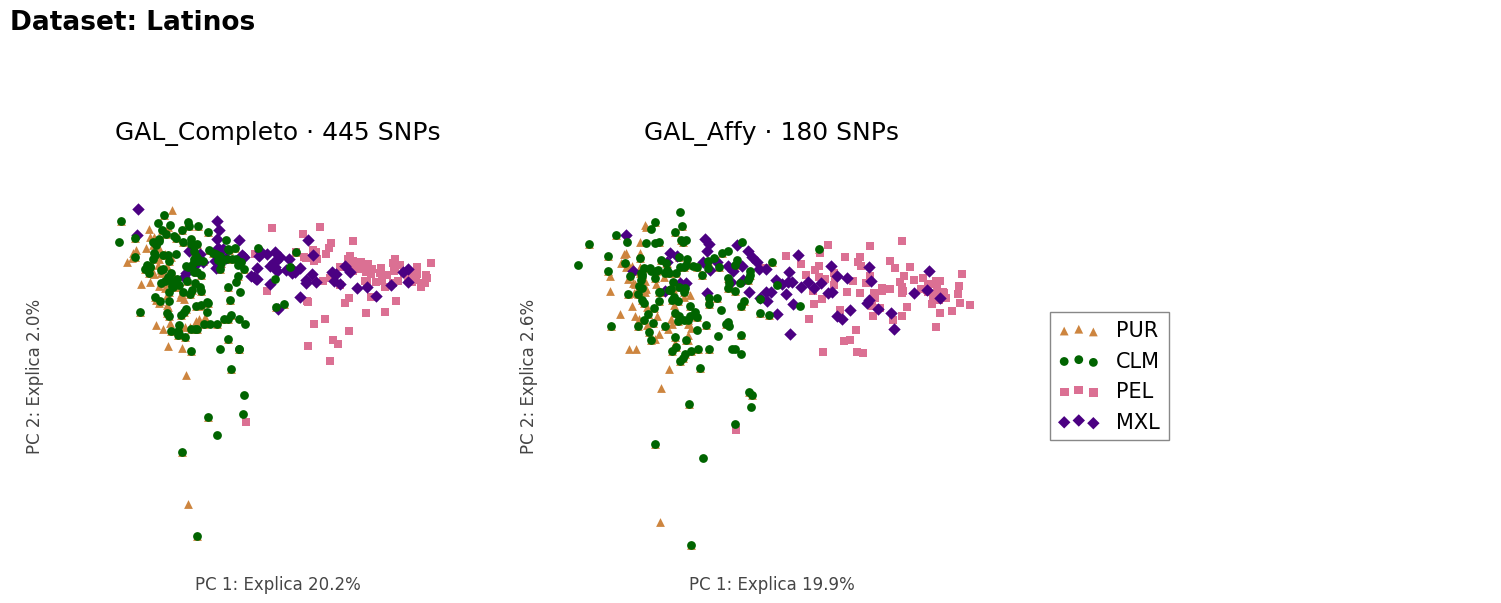

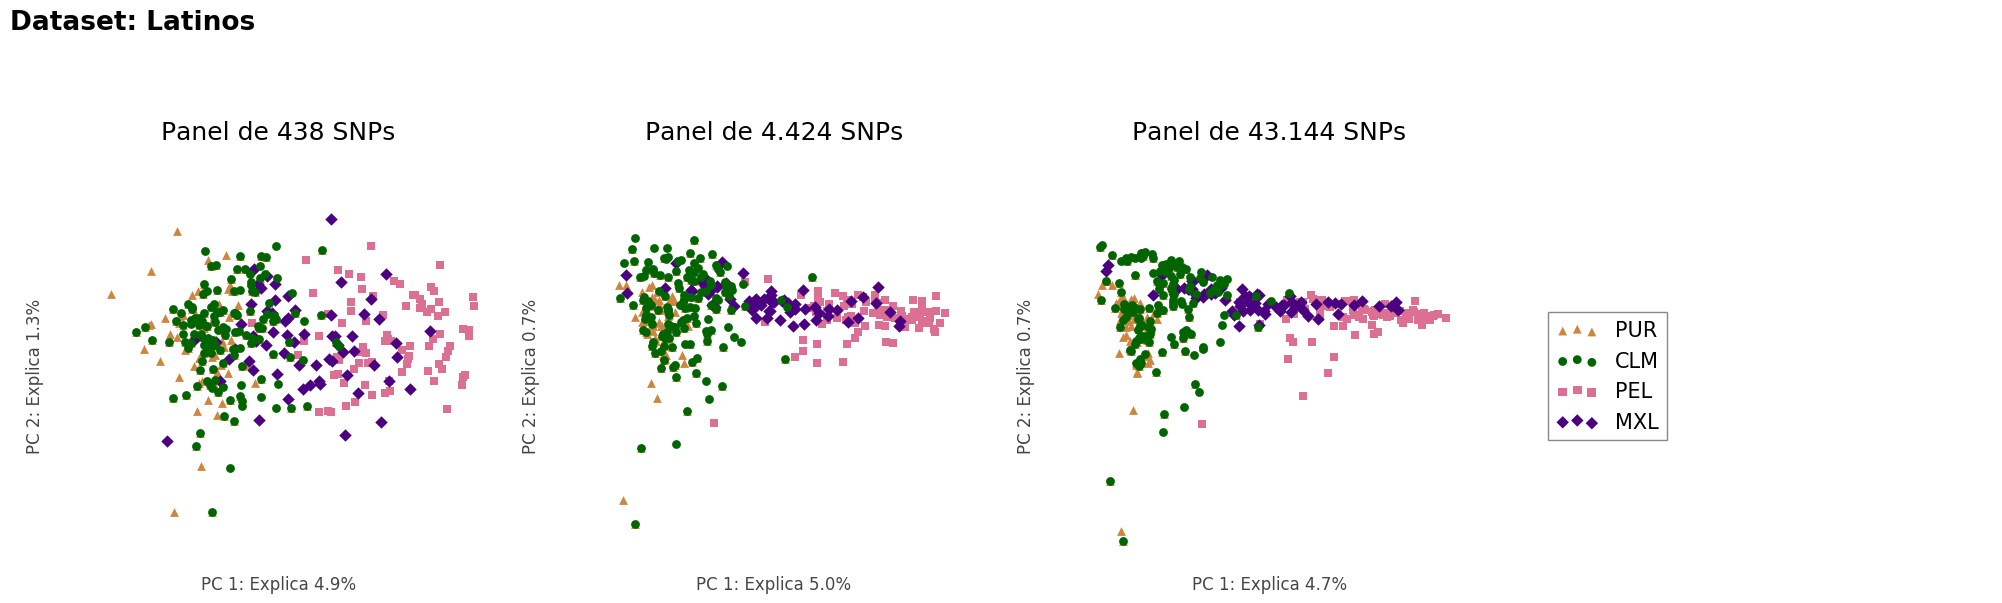

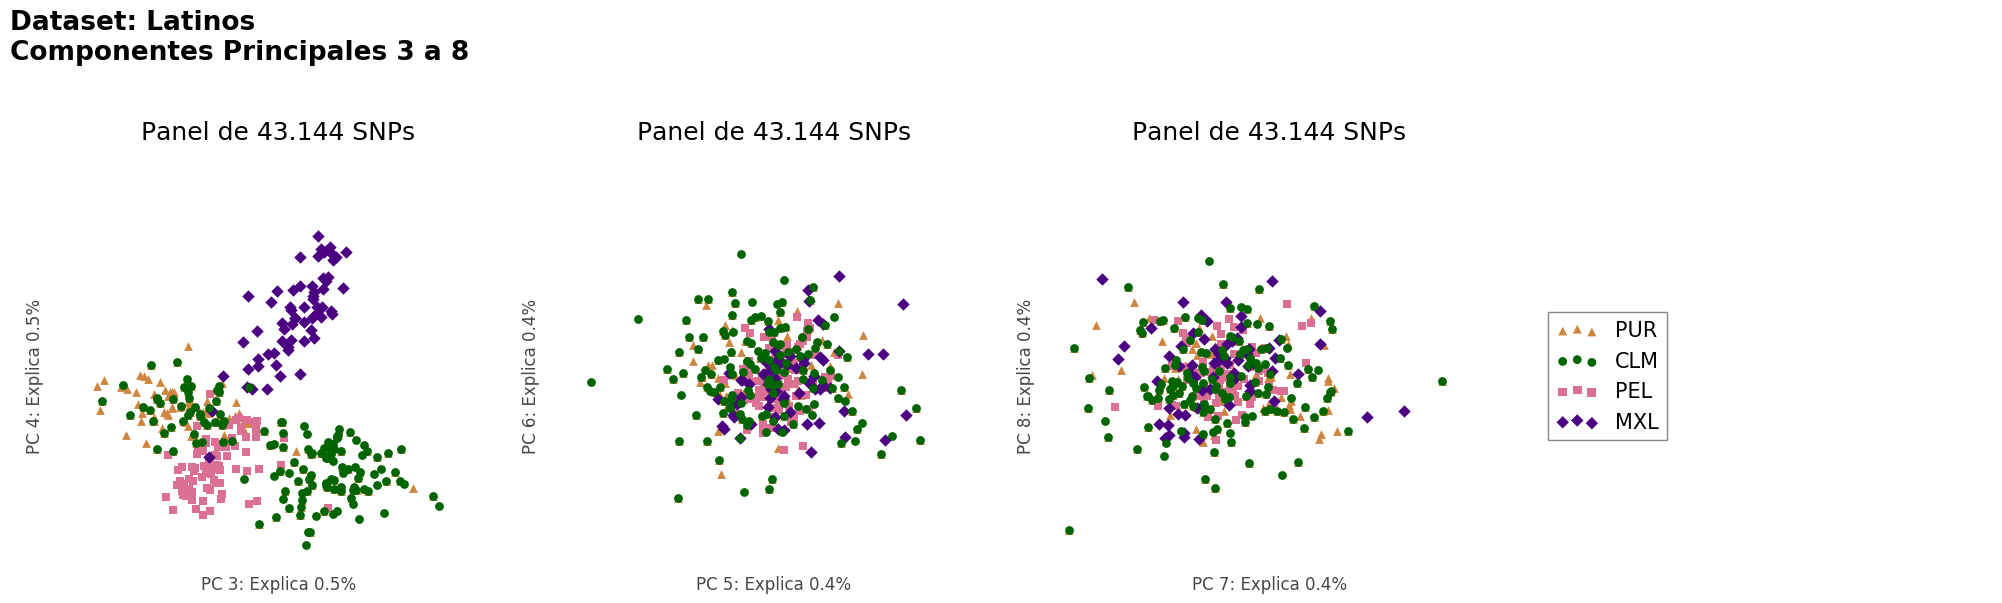

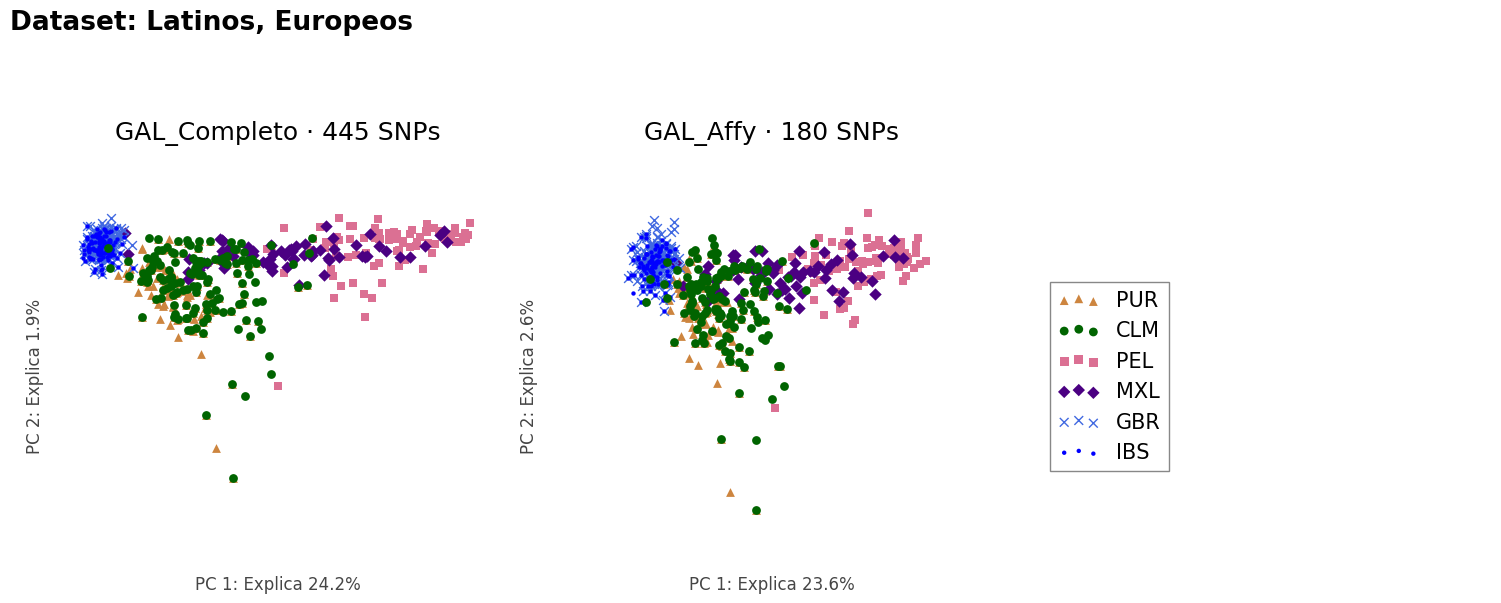

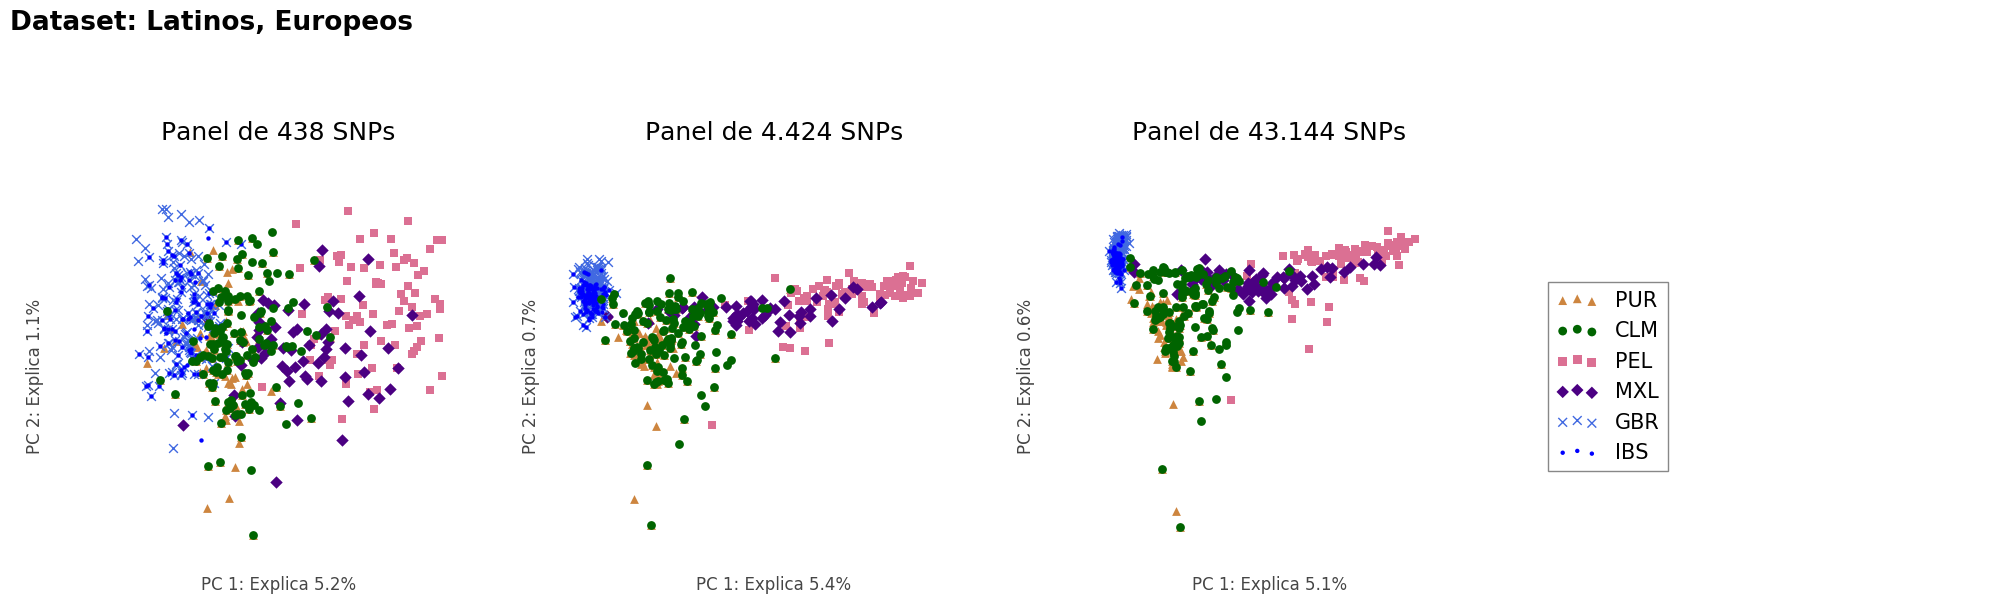

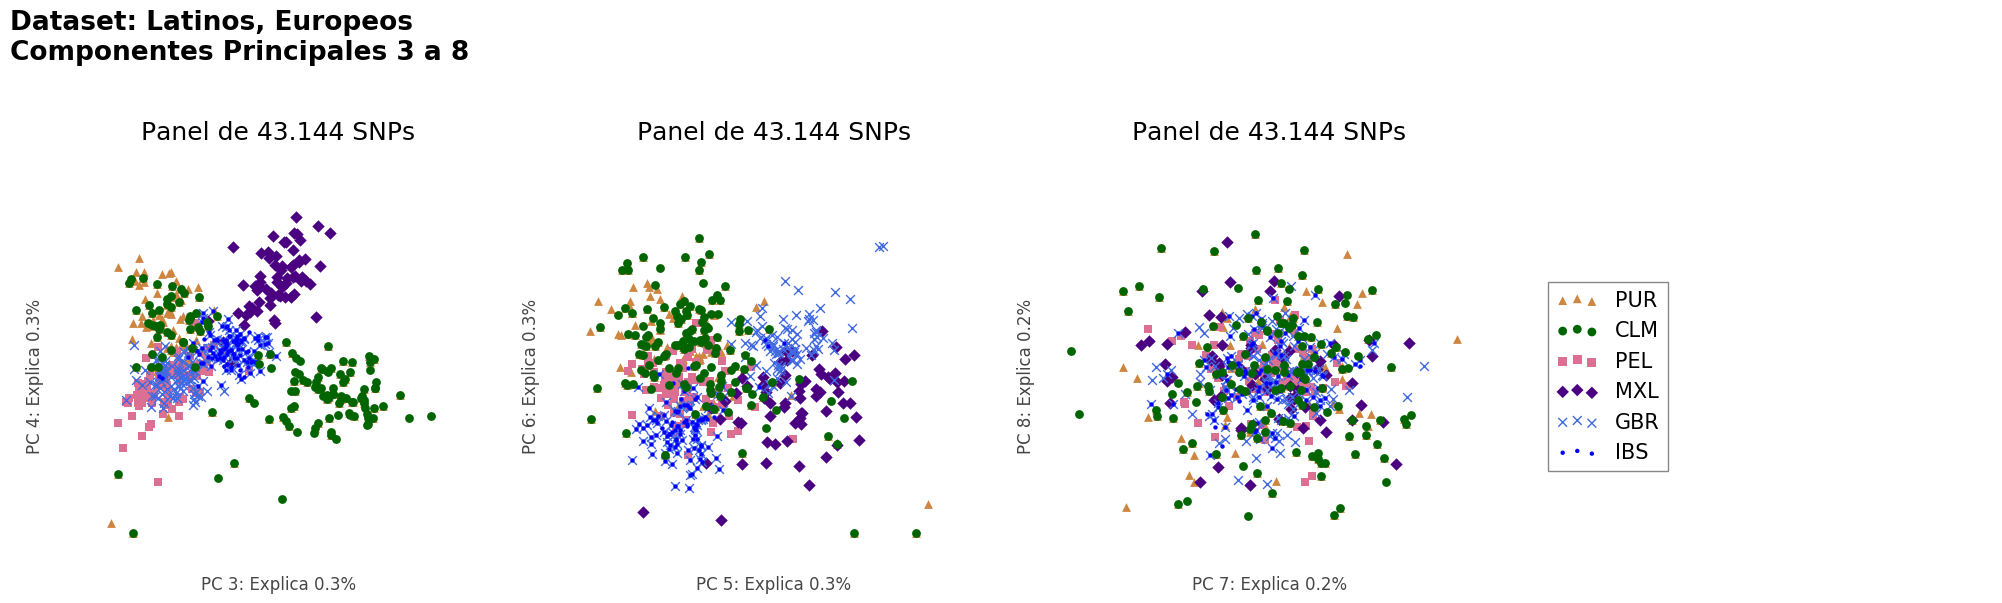

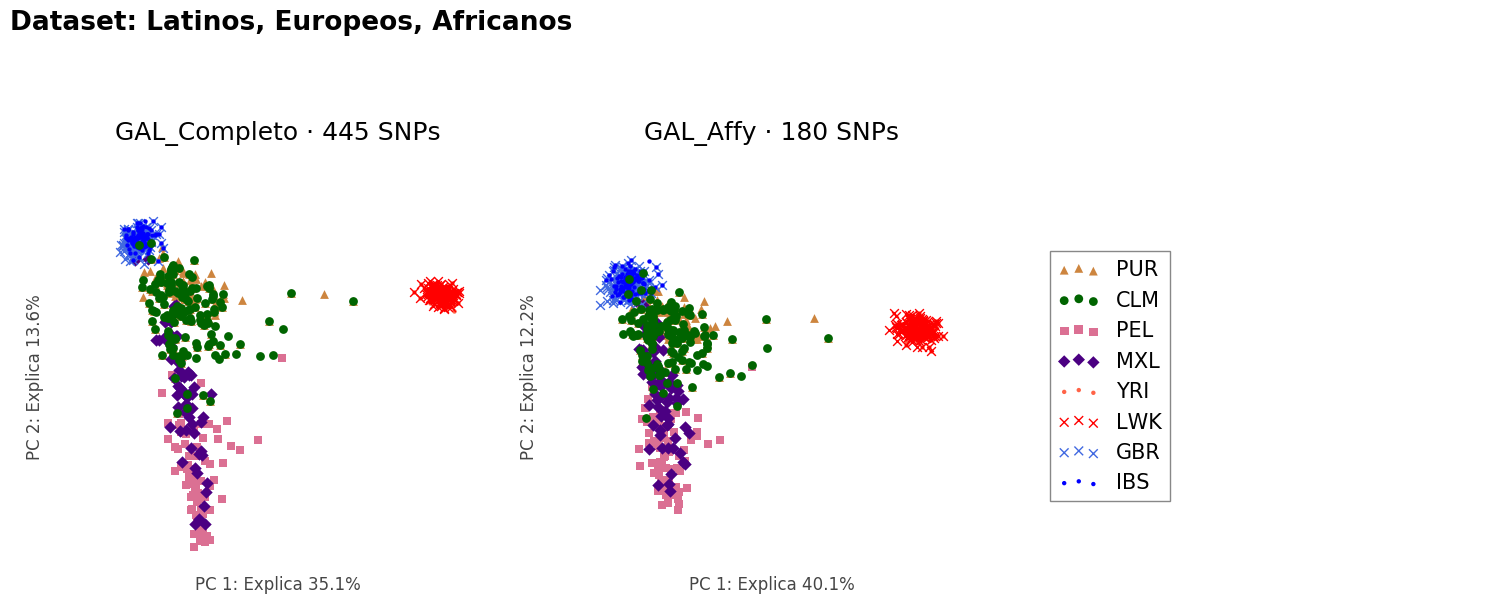

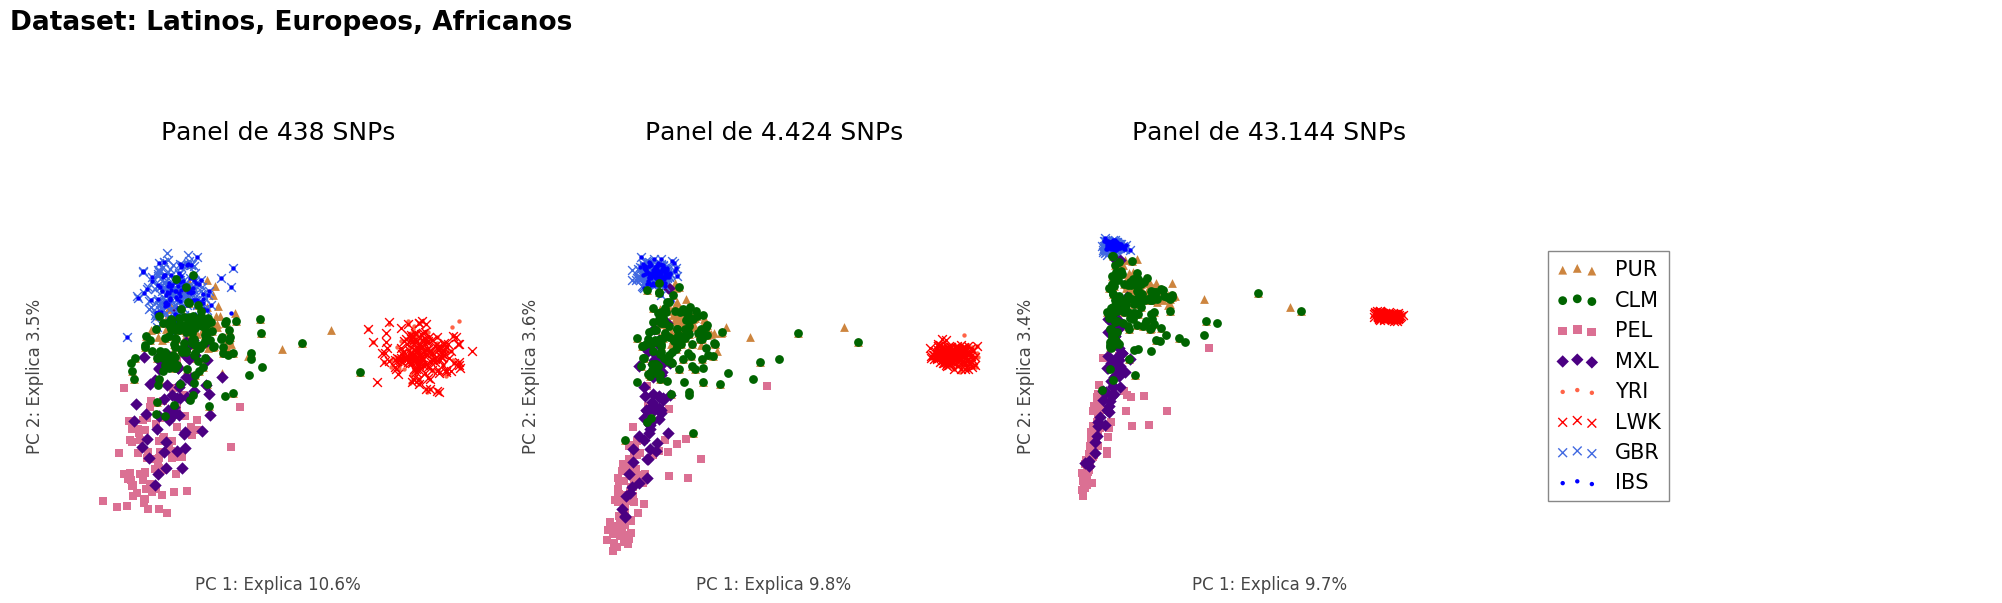

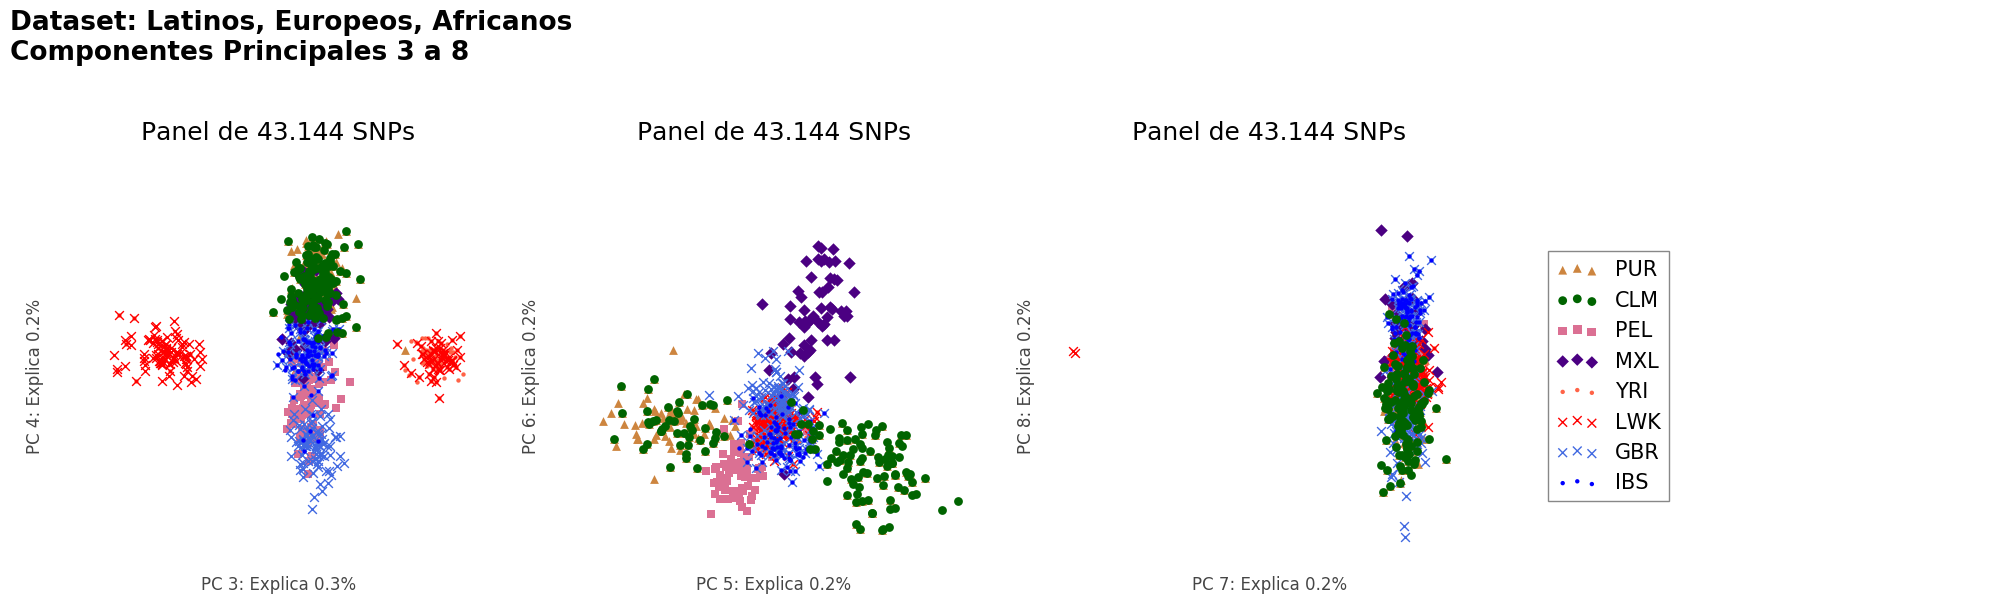

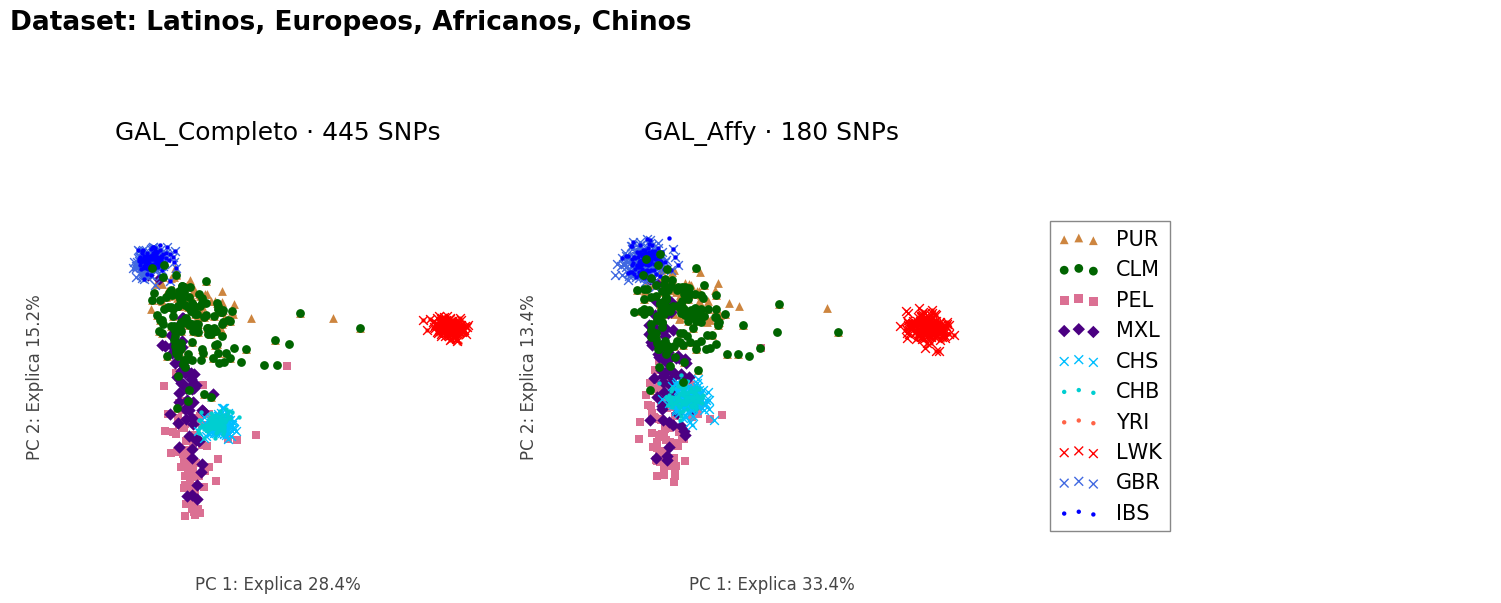

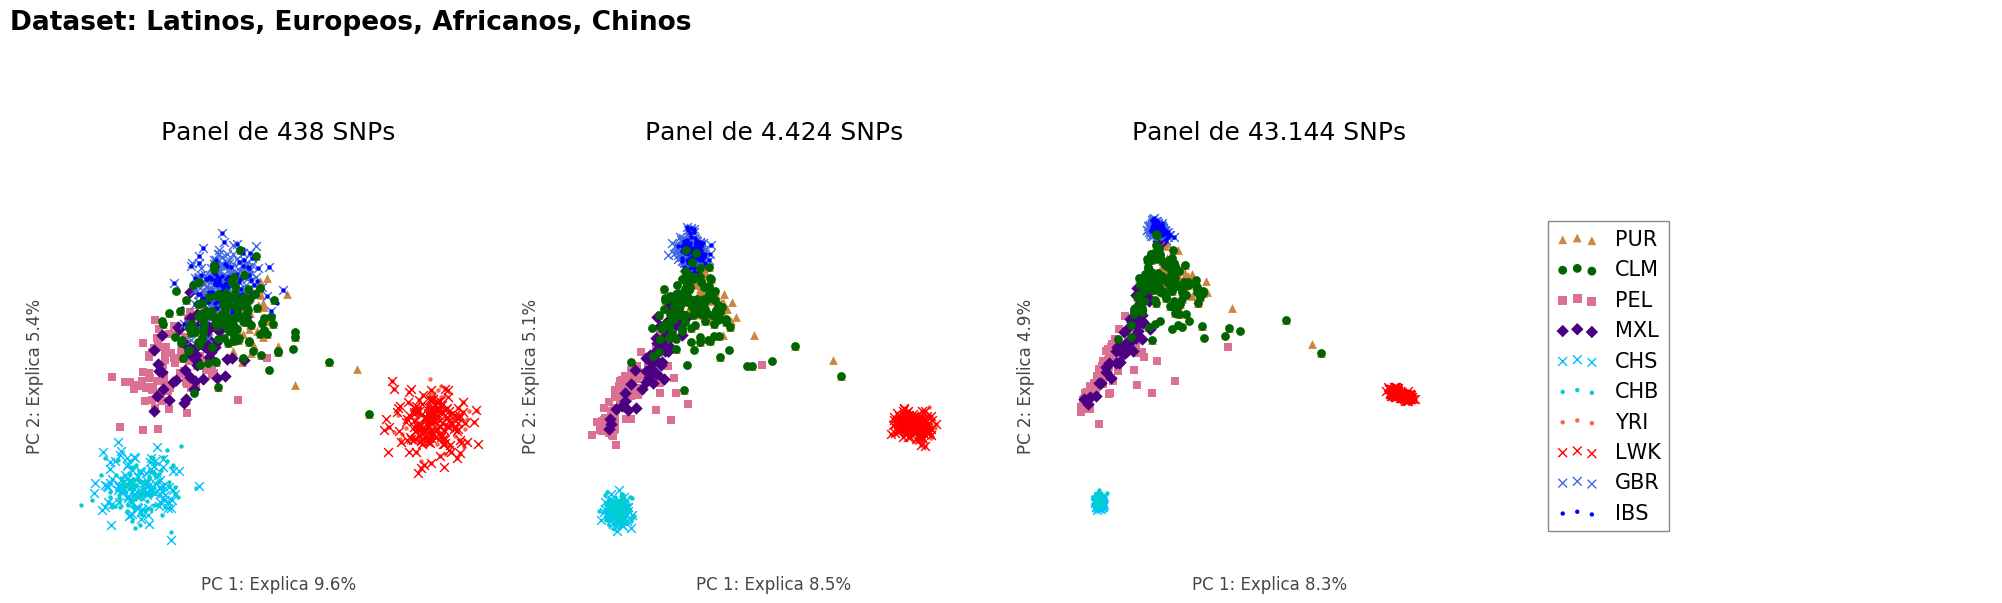

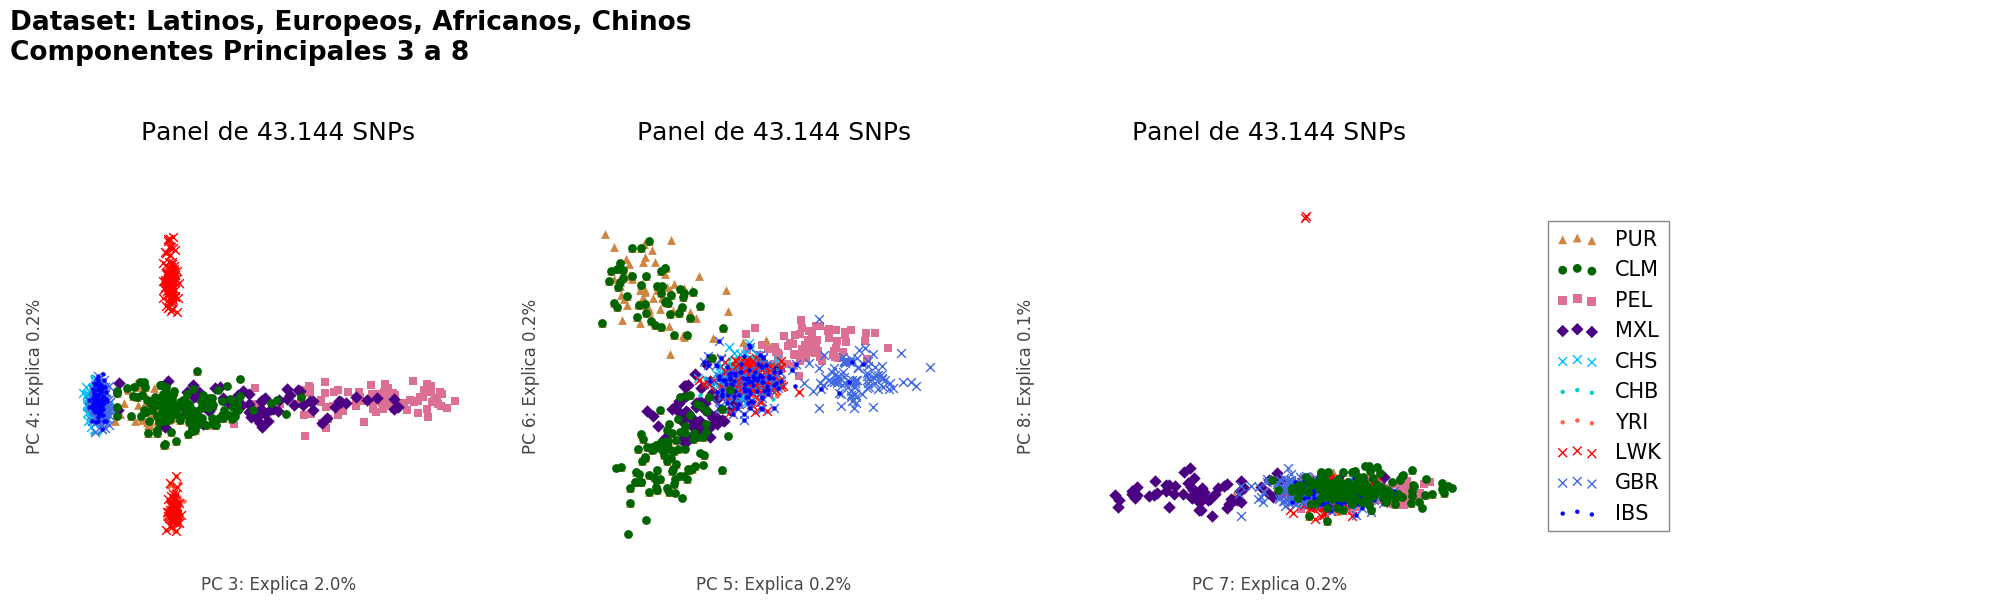

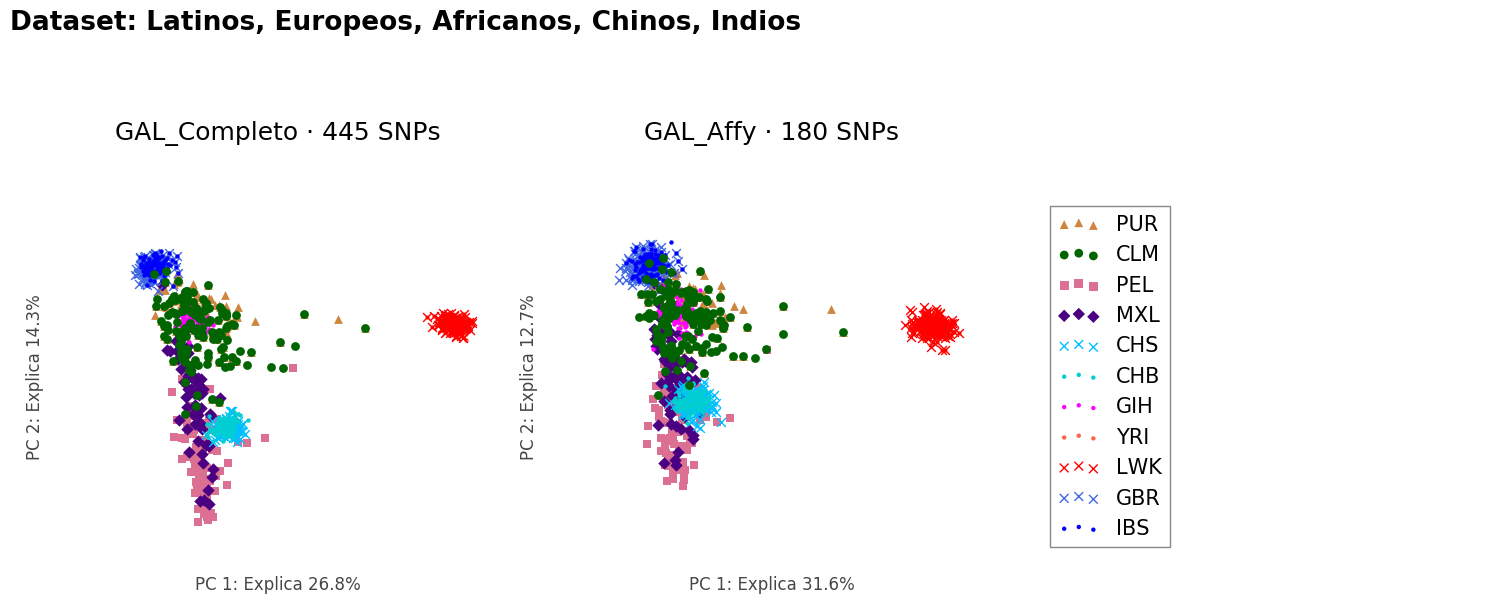

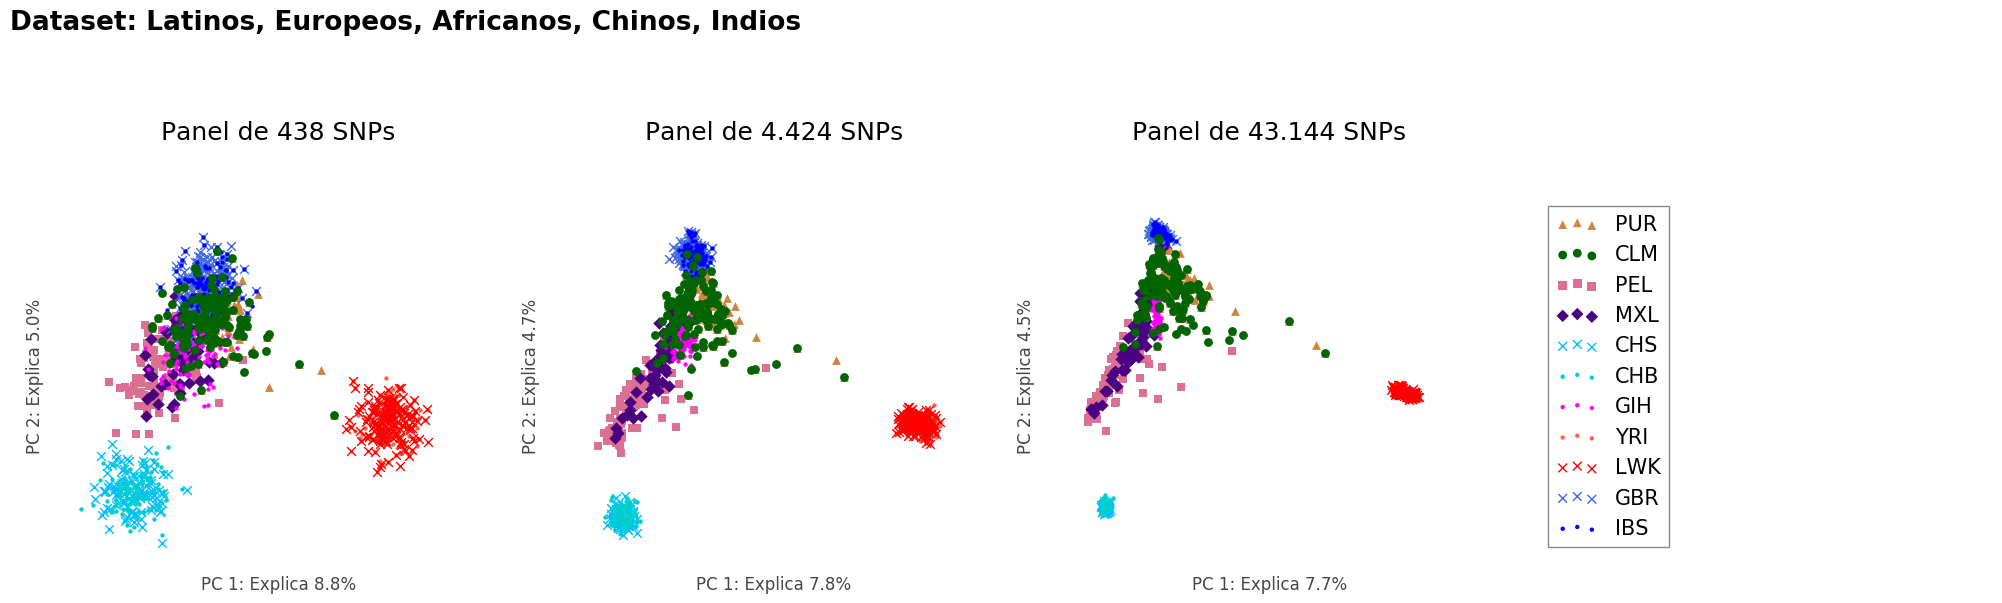

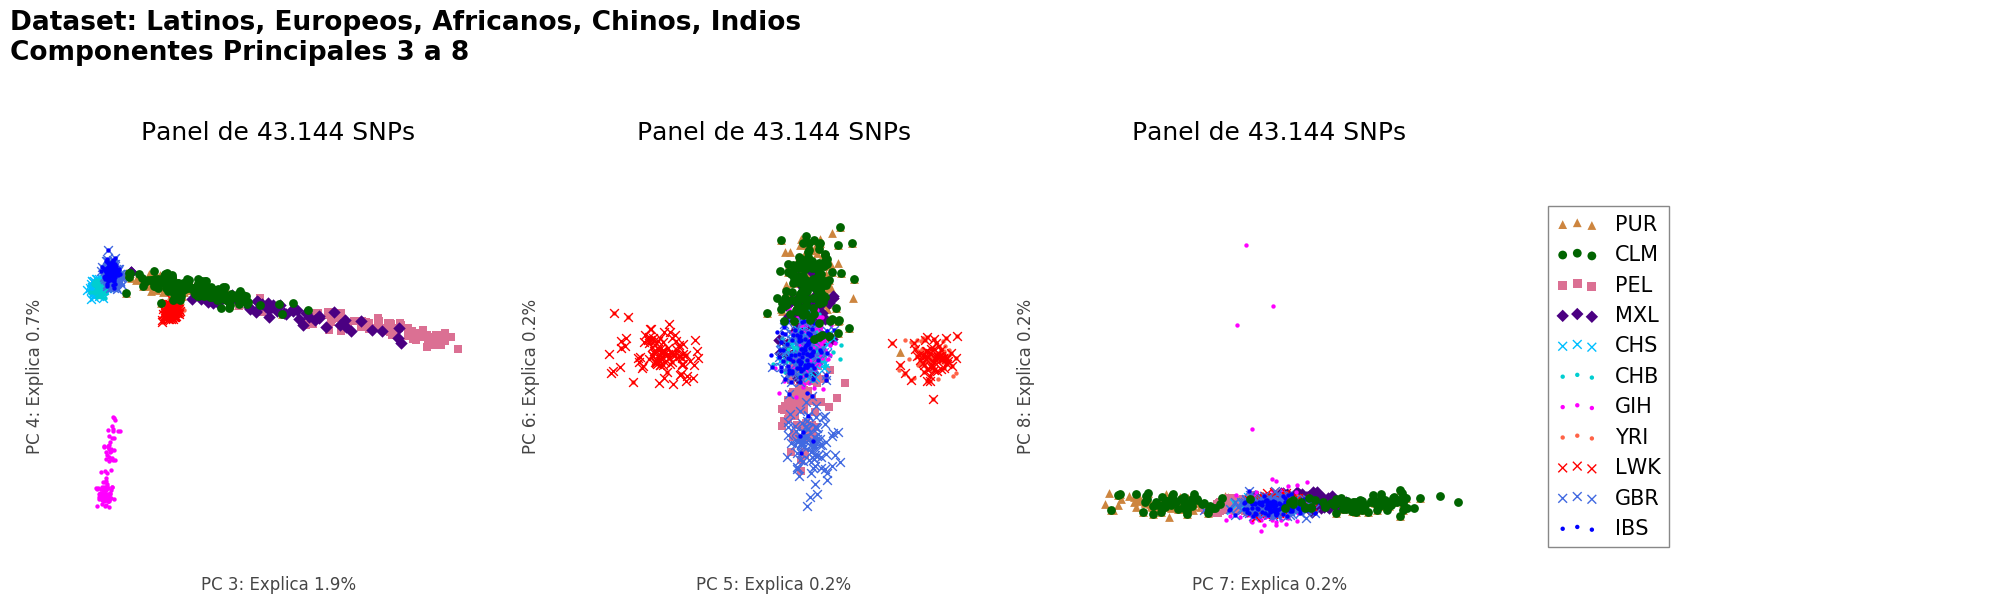

CPU times: user 11min 29s, sys: 2min 37s, total: 14min 6s
Wall time: 3min 56s


In [4]:
%%time

# == WARNING ==
# This cell will take ~4m to execute
# And it will take ~500 Mb RAM, I think

from plotters.pca import PCAPlotter

pca_plotter = PCAPlotter()
components_to_compare = [(0, 1)]

def make_filename(dataset_label, panel_labels, components_to_compare):
    return "{}_{}_PCx{}".format(dataset_label, "_".join(panel_labels).lower(),
                                len(components_to_compare) * 2)

for dataset_label, sample_ids in samples.items():
    fig_title = "Dataset: {}".format(dataset_names[dataset_label])
    
    # GAL Panles
    dataset_genotypes = df_1000G_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, panel_labels, components_to_compare)
    pca_plotter.plot(fig_title, panel_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, panel_names, filename)
    
    # Control Panels
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, cp_factors, components_to_compare)
    pca_plotter.plot(fig_title, control_rsIDs, dataset_genotypes, df_1000G_samples,
                     components_to_compare, control_names, filename)
    
    # Control Panels - Extra components
    only_big_cp = {"100": control_rsIDs["100"]}
    more_components_to_compare = [(2, 3), (4, 5), (6, 7)]
    dataset_genotypes = control_genotypes.loc[sample_ids, :]
    filename = make_filename(dataset_label, ["100"], more_components_to_compare)
    pca_plotter.plot(fig_title, only_big_cp, dataset_genotypes, df_1000G_samples,
                     more_components_to_compare, control_names, filename)